Vijay Samuel Alexander Vaseeharan - 012506546
Feature worked on - grammar and spelling errors on statements, religious context and overall polynomial equation



First we clone our repo from github to get the datasets

In [79]:
import numpy as np 
import pandas as pd
import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import linear_model

#clone our github project so that we can load in all datasets
!git clone https://github.com/kode-monkeys/AlternusVera.git

Cloning into 'AlternusVera'...
remote: Enumerating objects: 11, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 17 (delta 2), reused 10 (delta 2), pack-reused 6
Unpacking objects: 100% (17/17), done.


Create DFs for all the uploaded dataset files.

In [85]:
header_row = ["id","label","text","subject","speaker","title","state","party","barely true","false","half true","mostly true","pants on fire","context"]

df= pd.read_csv('AlternusVera/datasets/train.tsv',sep='\t',encoding='Latin1', names=header_row)
training = df
testing= pd.read_csv('AlternusVera/datasets/data.tsv',sep='\t',encoding='Latin1', names=header_row)
validation = pd.read_csv('AlternusVera/datasets/valid.tsv',sep='\t',encoding='Latin1', names=header_row)
df.head()

,id,label,text,subject,speaker,title,state,party,barely true,false,half true,mostly true,pants on fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [0]:
df['fake']=df['label']
df['fake']=np.where(df['label']=='half-true','true',df['fake'])
df['fake']=np.where(df['label']=='mostly-true','true',df['fake'])
df['fake']=np.where(df['label']=='barely-true','false',df['fake'])
df['fake']=np.where(df['label']=='pants-fire','false',df['fake'])

In [0]:
df.max()

id                                                       9998.json
label                                                         true
text             ï»¿ï»¿Since Mayor Kennedy OBrien took office S...
barely true                                                     70
false                                                          114
half true                                                      160
mostly true                                                    163
pants on fire                                                  105
fake                                                          true
dtype: object

In [0]:
df.min()

id                                                          1.json
label                                                  barely-true
text             #Business formation is still on the rise in Oh...
barely true                                                      0
false                                                            0
half true                                                        0
mostly true                                                      0
pants on fire                                                    0
fake                                                         false
dtype: object

Install all required packages and binaries needed for the workbook to work.

In [0]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install openjdk-8-jdk-headless -qq       #install openjdk
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"     #set environment variable
  os.environ["PATH"] = "/usr/lib/jvm/java-8-openjdk-amd64/bin:" + os.environ['PATH']
  !echo $PATH
  !java -version       #check java version
install_java()
!pip install language_check
!apt-get install python3-enchant > /dev/null
!pip install gensim

/usr/lib/jvm/java-8-openjdk-amd64/bin:/usr/local/bin:/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin
openjdk version "1.8.0_191"
OpenJDK Runtime Environment (build 1.8.0_191-8u191-b12-0ubuntu0.18.04.1-b12)
OpenJDK 64-Bit Server VM (build 25.191-b12, mixed mode)
  Using cached https://files.pythonhosted.org/packages/97/45/0fd1d3683d6129f30fa09143fa383cdf6dff8bc0d1648f2cf156109cb772/language-check-1.1.tar.gz
  Running setup.py bdist_wheel for language-check ... - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | done
  Stored in directory: /root/.cache/pip/wheels/d5/46/82/90a89c23eac1837364ed7217a9eed71bc9e6ad4825be93968e
Successfully built language-check


Use language check to define a method that can do a grammar check for all statements that are part of the dataset and create a field called "grammar_check" using that method for all 'text' fields entries.

In [0]:
import language_check
tool = language_check.LanguageTool('en-US')

def grammar_check(article):
  matches = tool.check(article)
  return len(matches)

In [0]:
df['grammar_error']=df['text'].map(lambda x: grammar_check(x))

Use pyenchant library to define a method which can do spelling checks on all the words of each sentence and report the count of all errors in a statement. A field called "spell_error" is created using this method. It is noted that feature importance shows spelling errors are more important than grammar errors. This is because news headlines tend to have grammar errors due to half sentences. Spelling errors are more common in articles from lesser reputed sources which are most likely to be fake


In [0]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import wordnet

import enchant
enchant = enchant.Dict("en_US")
def spell_check_article(article):
    article=article.replace('-',' ');
    article_tokenized=nltk.word_tokenize(article)
    total_word_count=len(article_tokenized)
    words_with_error_count=0
    for w in article_tokenized:
        if (not wordnet.synsets(w)) and (not enchant.check(w)):
            words_with_error_count+=1
    return words_with_error_count,(words_with_error_count/total_word_count*100)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [0]:
df['spell_error']=df['text'].map(lambda x: spell_check_article(x)[0])
df[['text','label','grammar_error', 'spell_error']][:25]

,text,label,grammar_error,spell_error
0,Says the Annies List political group supports ...,false,1,1
1,When did the decline of coal start? It started...,half-true,1,3
2,"Hillary Clinton agrees with John McCain ""by vo...",mostly-true,2,2
3,Health care reform legislation is likely to ma...,false,0,0
4,The economic turnaround started at the end of ...,half-true,0,0
5,The Chicago Bears have had more starting quart...,true,0,3
6,Jim Dunnam has not lived in the district he re...,barely-true,1,1
7,I'm the only person on this stage who has work...,half-true,1,4
8,"However, it took $19.5 million in Oregon Lotte...",half-true,0,2
9,Says GOP primary opponents Glenn Grothman and ...,mostly-true,2,3


In [0]:
df.context = pd.Categorical(df.context)
df['context_coded'] = df.context.cat.codes

df.fake = pd.Categorical(df.fake)
print(pd.Categorical(df.fake))
df['fake_coded'] = df.fake.cat.codes

[false, true, true, false, true, ..., true, true, true, false, false]
Length: 10240
Categories (2, object): [false, true]


Attempt to do logistic regression and random forest regression on the two newly created fields. 

In [0]:
features = ['grammar_error', 'spell_error']
X = df[features]
Y = df[['fake_coded']]
X = X.fillna(0);
Y = Y.fillna(0);
df['fake_coded'][:10]

0    0
1    1
2    1
3    0
4    1
5    1
6    0
7    1
8    1
9    1
Name: fake_coded, dtype: int8

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
lm = linear_model.LogisticRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [0]:
print(model)
print ("Score:", model.score(X_test, y_test))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Score: 0.5634765625


In [0]:
for i in range(0,len(model.coef_[0])):
    print (features[i], model.coef_[0][i])

grammar_error -0.08423055512576677
spell_error 0.04738859208969826


In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
No handles with labels found to put in legend.


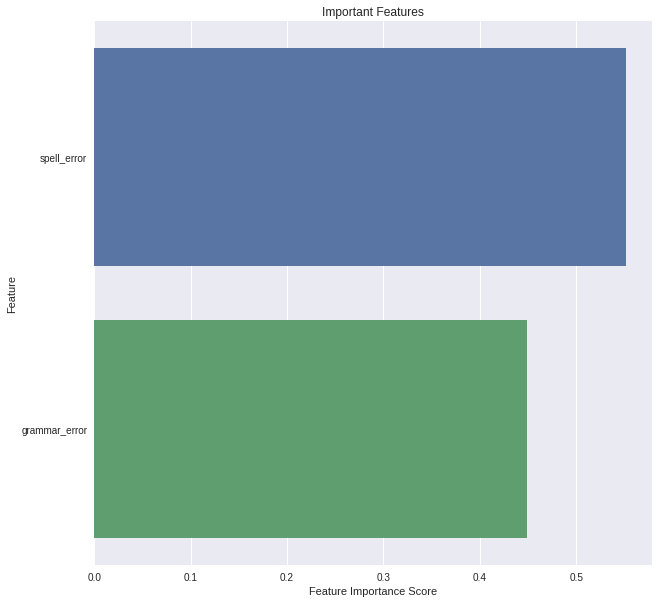

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
feature_imp = pd.Series(RF.feature_importances_,index=X_train.columns).sort_values(ascending=False)
index=X_train.columns
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title("Important Features")
plt.legend()
plt.show()

In [0]:
!pip install tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
import nltk
import nltk.corpus 
from nltk.tokenize import word_tokenize
import csv

In [0]:
my_dictionary = "islam christian christianity God Allah Christ isreal arab religion bible quoran synagogue church mosque temple genesis revelations mathew john mark luke moses david solomon anti-christ book prayer heaven hell paradise sunni shia" 


In [0]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize 
nltk.download('punkt')

def TextCleansing(txt):
    rem = re.sub('[^a-zA-Z]', ' ', txt)
    rem = rem.lower()
    rem = rem.split()
    ps = PorterStemmer()
    rem = [ps.stem(word) for word in rem if not word in set(stopwords.words('english'))]
    rem = ' '.join(rem)
    return rem

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
stop_words=set(stopwords.words('english'))


In [0]:
TextCleansing(my_dictionary)


'islam christian christian god allah christ isreal arab religion bibl quoran synagogu church mosqu templ genesi revel mathew john mark luke mose david solomon anti christ book prayer heaven hell paradis sunni shia'

In [0]:
def cleaning(raw_news):
    import nltk    
    news = re.sub("[^a-zA-Z]", " ", raw_news)    
    news =  news.lower()     
    news_words = nltk.word_tokenize( news)        
    stops = set(nltk.corpus.stopwords.words("english"))       
    words = [w for w in  news_words  if not w in stops]        
    stems = [nltk.stem.SnowballStemmer('english').stem(w) for w in words]     
    return " ".join(stems)
  
import re
training['text'] = training["text"].apply(cleaning) 
testing['text'] = testing["text"].apply(cleaning)

In [0]:
corpus = []
import gensim
from nltk.tokenize import word_tokenize

for text in training['text']:
    corpus.append(text)
corpus.append(my_dictionary)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [0]:
X = vectorizer.fit_transform(corpus)

In [0]:
from scipy import spatial
sims = []
for i in range(10240):
    cos_statement1 = 1 - spatial.distance.cosine(X[i].toarray(), X[10240].toarray())
    sims.append(cos_statement1)

print(len(df), len(sims))
df['religion'] = sims

10240 10240


In [0]:
features = ['grammar_error', 'spell_error', 'religion']
X = df[features]
Y = df[['fake_coded']]
X = X.fillna(0);
Y = Y.fillna(0);


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train,y_train)
print ("Score:", RF.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Score: 0.558349609375


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
No handles with labels found to put in legend.


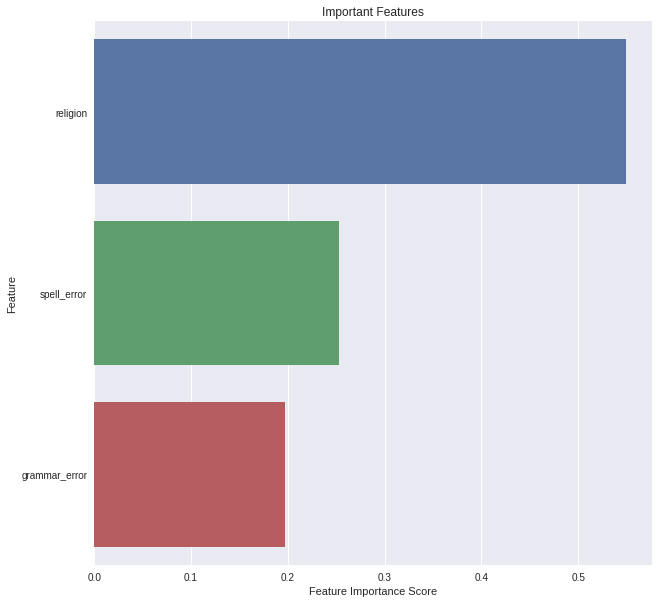

religion         0.549071
spell_error      0.253349
grammar_error    0.197580
dtype: float64


In [0]:
feature_imp = pd.Series(RF.feature_importances_,index=X_train.columns).sort_values(ascending=False)
index=X_train.columns
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title("Important Features")
plt.legend()
plt.show()
print(feature_imp)

Importing entire notebooks is hard so we import the features via csv files and create dataframes out of them.

In [0]:
l_df = pd.read_csv('AlternusVera/datasets/train_lexical.csv')
h_df = pd.read_csv('AlternusVera/datasets/Headlines_Stance_Data_final.csv')
cor_df = pd.read_csv('AlternusVera/datasets/title_correlation.csv')
cont_df = pd.read_csv('AlternusVera/datasets/controversy.csv')
sens_df = pd.read_csv('AlternusVera/datasets/sensation.csv')
hs_df = pd.read_csv('AlternusVera/datasets/hate_speech_factor.csv')
t_df = pd.read_csv('AlternusVera/datasets/trolling_factor_csv_file_with_header.csv')
pa_df = pd.read_csv('AlternusVera/datasets/Party_Affliation_Factors_for_predicting_fake_news.csv')

In [0]:
sens_df.head()

,label,statement,length,sensationalism
0,half-true,declin coal start start natur gas took start b...,80,0.000000
1,mostly-true,hillari clinton agr john mccain vote give geor...,72,0.000000
2,false,health care reform legisl like mandat free sex...,60,0.000000
3,half-true,econom turnaround start end term,32,0.000000
4,true,chicago bear start quarterback last year total...,90,0.023431


In [0]:
print(hs_df.head())
print(t_df.head())
print(pa_df.head())

   Unnamed: 0  hate_speech_confidence  offsensive_speech_confidence  \
0           0            1.679667e-08                      0.258597   
1           1            6.592088e-10                      0.619811   
2           2            4.650032e-06                      0.335105   
3           3            3.113943e-09                      0.661825   
4           4            1.312405e-04                      0.054103   

   clean_speech_confidence  copy_of_fake_label_from_liar_liar  
0                 0.741403                                  0  
1                 0.380189                                  1  
2                 0.664890                                  1  
3                 0.338175                                  0  
4                 0.945766                                  1  
   Unnamed: 0     troll label_from_liar_liar_copy
0           0  0.631423                     false
1           1  0.664333                 half-true
2           2  0.631605               m

We add the features from all other team mates work into this data frame to create one that has all features. 

In [0]:
df['hate_speech_confidence'] = hs_df['hate_speech_confidence']
df['offsensive_speech_confidence'] = hs_df['offsensive_speech_confidence']
df['clean_speech_confidence'] = hs_df['clean_speech_confidence']
df['troll'] = t_df['troll']
df['lexical_factor_vector_score'] = l_df['lexical_factor_vector_score']
df['compound'] = l_df['lexical_factor_vector_score']
df['confidence_republican'] = pa_df['confidence_republican']
df['confidence_democrat'] = pa_df['confidence_democrat']
df['confidence_no_affliation'] = pa_df['confidence_no_affliation']
df['confidence_other'] = pa_df['confidence_other']
df['predicted_party'] = pa_df['predicted_party']
df['headline_polarity'] = h_df['headline_polarity']
df['compound_stance'] = h_df['compound']
df['neg'] = h_df['neg']
df['neu'] = h_df['neu']
df['pos'] = h_df['pos']
df['title-body Doc2Vec-cosine-similarity'] = cor_df['title-body Doc2Vec-cosine-similarity']
df['body-title sentiment-correlation'] = cor_df['body-title sentiment-correlation']
df['lda-bow title-body-correlation'] = cor_df['lda-bow title-body-correlation']
df['lda-tfidf title-body-correlation'] = cor_df['lda-tfidf title-body-correlation']
df['Controversial'] = cont_df['Controversial']
df['sensationalism'] = sens_df['sensationalism']

In [0]:
tempdf = cor_df[['title-body Doc2Vec-cosine-similarity', 'body-title sentiment-correlation', 'lda-bow title-body-correlation', 'lda-tfidf title-body-correlation']]
tempdf.to_csv('title_correlation.csv')
files.download('title_correlation.csv')

In [0]:
df.head()

,id,label,text,subject,speaker,title,state,party,barely true,false,...,compound_stance,neg,neu,pos,title-body Doc2Vec-cosine-similarity,body-title sentiment-correlation,lda-bow title-body-correlation,lda-tfidf title-body-correlation,Controversial,sensationalism
0,2635.json,false,say anni list polit group support third trimes...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,...,0.2500,0.115,0.692,0.192,-0.176395,0.7504,0.918997,0.824029,0.0,0.000000
1,10540.json,half-true,declin coal start start natur gas took start b...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,...,0.3612,0.000,0.902,0.098,0.278762,0.2960,0.979303,0.974556,0.0,0.000000
2,324.json,mostly-true,hillari clinton agre john mccain vote give geo...,foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,...,0.3182,0.107,0.687,0.206,0.056696,0.9042,0.983626,0.978959,0.0,0.000000
3,1123.json,false,health care reform legisl like mandat free sex...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,...,0.7579,0.000,0.606,0.394,0.112031,1.4691,0.731893,1.000000,0.0,0.000000
4,9028.json,half-true,econom turnaround start end term,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,...,0.0000,0.000,1.000,0.000,-0.130028,0.9517,0.985603,0.982234,0.0,0.023431


We run Logistic regression and Random Forest regression to get the coefficients and feature importances for each feature. We will use it to generate a polynomial equation to determine fakeness


In [0]:
#features = ['grammar_error', 'spell_error', 'religion', 'hate_speech_confidence', 'offsensive_speech_confidence', 'clean_speech_confidence', 'troll', 'lexical_factor_vector_score', "barely true","false","half true","mostly true","pants on fire", 'compound_stance',	'neg',	'neu',	'pos', 'headline_polarity', 'confidence_republican', 'confidence_democrat', 'confidence_no_affliation',  'confidence_other']
features = ['grammar_error', 'spell_error', 'religion', 'hate_speech_confidence', 'offsensive_speech_confidence', 'clean_speech_confidence', 'troll', 'lexical_factor_vector_score', "barely true","false","half true","mostly true","pants on fire", 'compound_stance',	'neg',	'neu',	'pos', 'headline_polarity', 'confidence_republican', 'confidence_democrat', 'confidence_no_affliation',  'confidence_other', 'sensationalism', 'Controversial', 'title-body Doc2Vec-cosine-similarity','body-title sentiment-correlation','lda-bow title-body-correlation','lda-tfidf title-body-correlation']
X = df[features]
Y = df[['fake_coded']]
X = X.fillna(0);
Y = Y.fillna(0);


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=0)
RF = RandomForestClassifier(n_estimators=100)
RF.fit(X_train,y_train)
print ("Score:", RF.score(X_test, y_test))
a = RF.predict_proba(X_test)
b = RF.predict(X_test)
print(y_test[:10])
print(a[:10])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Score: 0.716796875
      fake_coded
2730           0
39             1
528            1
2075           1
3896           1
8151           1
8024           1
2782           1
8428           0
9863           0
[[0.62 0.38]
 [0.39 0.61]
 [0.39 0.61]
 [0.41 0.59]
 [0.28 0.72]
 [0.21 0.79]
 [0.27 0.73]
 [0.02 0.98]
 [0.16 0.84]
 [0.45 0.55]]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
No handles with labels found to put in legend.


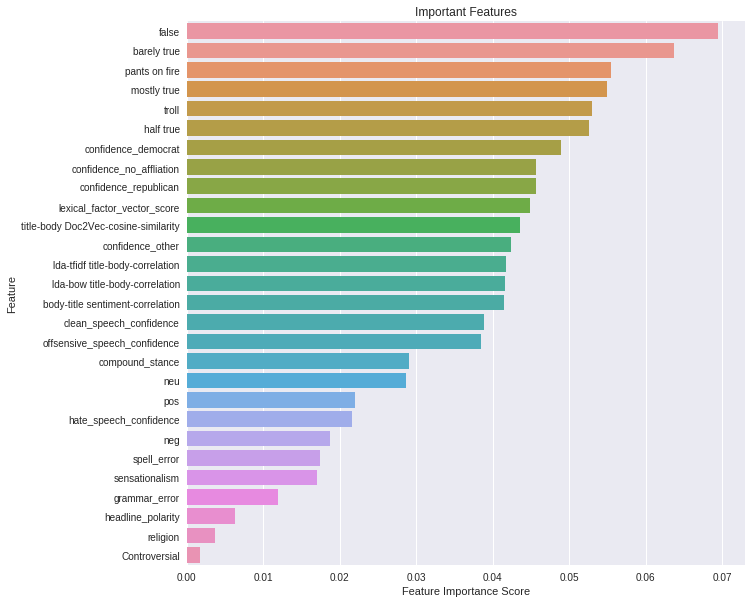

false                                   0.069451
barely true                             0.063697
pants on fire                           0.055385
mostly true                             0.054880
troll                                   0.052943
half true                               0.052548
confidence_democrat                     0.048883
confidence_no_affliation                0.045632
confidence_republican                   0.045599
lexical_factor_vector_score             0.044849
title-body Doc2Vec-cosine-similarity    0.043606
confidence_other                        0.042310
lda-tfidf title-body-correlation        0.041656
lda-bow title-body-correlation          0.041594
body-title sentiment-correlation        0.041469
clean_speech_confidence                 0.038876
offsensive_speech_confidence            0.038447
compound_stance                         0.029064
neu                                     0.028709
pos                                     0.021952
hate_speech_confiden

In [0]:
feature_imp = pd.Series(RF.feature_importances_,index=X_train.columns).sort_values(ascending=False)
index=X_train.columns
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title("Important Features")
plt.legend()
plt.show()
print(feature_imp)

In [0]:
lm = linear_model.LogisticRegression()
model = lm.fit(X_train, y_train)
predictions = lm.predict(X_test)
print(model)
print ("Score:", model.score(X_test, y_test))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Score: 0.602294921875


In [0]:
for i in range(0,len(model.coef_[0])):
    print (features[i], model.coef_[0][i])

grammar_error -0.06782130729525217
spell_error 0.00973070799969336
religion -0.37821596367443827
hate_speech_confidence 0.22179065390343028
offsensive_speech_confidence -0.6954199400672489
clean_speech_confidence -0.5776482575765258
troll 3.7430628129810866
lexical_factor_vector_score 0.005937309210522443
barely true -0.015907728063848298
false 0.0002847153983823605
half true 0.012141837617036922
mostly true 0.0015617124451878545
pants on fire -0.02149300354765071
compound_stance -0.1109818712393586
neg 0.057962420066082536
neu -0.09188996822596882
pos -1.0290077360922947
headline_polarity 0.06679666716746976
confidence_republican -0.4681475311309757
confidence_democrat -0.08525806808368233
confidence_no_affliation -0.40466847152750324
confidence_other -0.09320493693705045
sensationalism 0.16211412607271472
Controversial 0.15829558515811565
title-body Doc2Vec-cosine-similarity 0.19083921147340285
body-title sentiment-correlation 0.06958365095431432
lda-bow title-body-correlation -0.176

We create a polynomial equation out of the feature weights that are available 

In [0]:
equation =  "Y = "
i = 0;
for x in feature_imp:
  equation = equation + " + (" + features[i] + "*" + str(round(x, 2)) + ")"
  i = i + 1
  

i = 0
print(equation)
print("Feature Importances:")
for x in feature_imp:
  print(features[i], ":", round(x, 2))
  i = i + 1

Y =  + (grammar_error*0.07) + (spell_error*0.06) + (religion*0.06) + (hate_speech_confidence*0.05) + (offsensive_speech_confidence*0.05) + (clean_speech_confidence*0.05) + (troll*0.05) + (lexical_factor_vector_score*0.05) + (barely true*0.05) + (false*0.04) + (half true*0.04) + (mostly true*0.04) + (pants on fire*0.04) + (compound_stance*0.04) + (neg*0.04) + (neu*0.04) + (pos*0.04) + (headline_polarity*0.03) + (confidence_republican*0.03) + (confidence_democrat*0.02) + (confidence_no_affliation*0.02) + (confidence_other*0.02) + (sensationalism*0.02) + (Controversial*0.02) + (title-body Doc2Vec-cosine-similarity*0.01) + (body-title sentiment-correlation*0.01) + (lda-bow title-body-correlation*0.0) + (lda-tfidf title-body-correlation*0.0)
Feature Importances:
grammar_error : 0.07
spell_error : 0.06
religion : 0.06
hate_speech_confidence : 0.05
offsensive_speech_confidence : 0.05
clean_speech_confidence : 0.05
troll : 0.05
lexical_factor_vector_score : 0.05
barely true : 0.05
false : 0.04

Model Accuracy for PolynomialEquation: 72.0 %


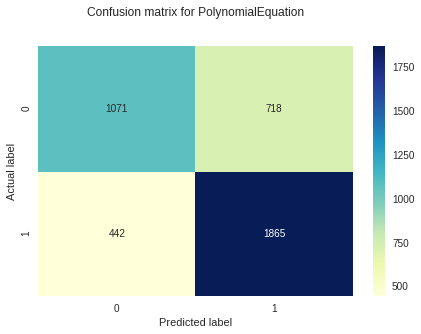

In [0]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
cm = confusion_matrix(y_test, b)

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')

plt.tight_layout()
plt.title('Confusion matrix for PolynomialEquation', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
print("Model Accuracy for PolynomialEquation:",round(metrics.accuracy_score(y_test, b), 2) * 100, "%")